In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchaudio
import torch
import numpy as np
import pandas as pd
import os
import pickle
import re
import torchaudio.transforms as T
import math
import librosa
import librosa.display
import matplotlib.patches as patches
from glob import glob
import util
from util import audio_file
from util import *
from Losses import FocalLoss,WeightedFocalLoss
from StackedLSTM2 import StackedLSTM
from AttentionLSTM import Attention_LSTM
from Toy_Model import ToyModel
import time
import parselmouth
torch.manual_seed(1)

'''input_list, labels_list = load_data_limit(6)
n_samples = input_list.size()[0]
train_split = 4*n_samples//5
test_samples = n_samples - train_split
test_input_list = input_list[train_split:]
test_labels_list = labels_list[train_split:]
input_list = input_list[:train_split]
labels_list = labels_list[:train_split]
input_list.shape
print("done")'''

'input_list, labels_list = load_data_limit(6)\nn_samples = input_list.size()[0]\ntrain_split = 4*n_samples//5\ntest_samples = n_samples - train_split\ntest_input_list = input_list[train_split:]\ntest_labels_list = labels_list[train_split:]\ninput_list = input_list[:train_split]\nlabels_list = labels_list[:train_split]\ninput_list.shape\nprint("done")'

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchaudio
import sys
import torch
import numpy as np
import pandas as pd
import os
import pickle
import re
import torchaudio.transforms as T
import math
import librosa
import librosa.display
import matplotlib.patches as patches
from glob import glob
import util
from util import audio_file
from util import *
from Losses import FocalLoss,WeightedFocalLoss
from StackedLSTM2 import StackedLSTM
from AttentionLSTM import Attention_LSTM
from Toy_Model import ToyModel
import time
torch.manual_seed(1)

my_dataset = "BPC"
my_model = "Attention_LSTM"
verbose = 1

if my_dataset == "ATC0":
    input_list, labels_list = process_atc0_files()
    
elif my_dataset == "BPC":
    input_list, labels_list = load_data()

n_samples = input_list.size()[0]
train_split = 4*n_samples//5
test_samples = n_samples - train_split
    
test_input_list = input_list[train_split:]
test_labels_list = labels_list[train_split:]
input_list = input_list[:train_split]
labels_list = labels_list[:train_split]

if my_model == "Attention_LSTM":
    model = Attention_LSTM()
    if my_dataset == "ATC0":
        load_filepath = '/project/graziul/ra/ajays/lang-of-pol/vad/Attention_model_atc0/model_weights_atc0.pt'
    elif my_dataset == "BPC":
        load_filepath = '/project/graziul/ra/ajays/lang-of-pol/vad/Attention_model/model_weights.pt'
        
elif my_model == "Vanilla_LSTM":
    model = ToyModel()
    if my_dataset == "ATC0":
        load_filepath = '/project/graziul/ra/ajays/lang-of-pol/vad/LSTM_layer_model_atc0/model_weights_atc0.pt'
    elif my_dataset == "BPC":
        load_filepath = '/project/graziul/ra/ajays/lang-of-pol/vad/LSTM_layer_model/model_weights.pt'
        
model.load_state_dict(torch.load(load_filepath))    

0
(180600,)
1
(180600,)
2
(180600,)
3
(180600,)
4
(180600,)
5
(180600,)
6
(180600,)
7
(180600,)
8
(180600,)
9
(180600,)
10
(180600,)
11
(180600,)
12
(180600,)
13
(180600,)
14
(180600,)
15
(180600,)
16
(180600,)
17
(180600,)
18
(180600,)
19
(180600,)
20
(180600,)
21
(180600,)
22
(180600,)
23
(180600,)
24
(180600,)
25
(180600,)
26
(180600,)
27
(180600,)
28
(180600,)
29
(180600,)
30
(180600,)
31
(180600,)
32
(180600,)
33
(180600,)
34
(180600,)
35
(180600,)
36
(180600,)
37
(180600,)
38
(180600,)
39
(180600,)
40
(180600,)
41
(180600,)
42
(180600,)
43
(180600,)
44
(180600,)
45
(180600,)
46
(180600,)
47
(180600,)
48
(180600,)
49
(180600,)
50
(180600,)
51
(180600,)
52
(180600,)
53
(180600,)
54
(180600,)
55
(180600,)
56
(180600,)
57
(180600,)
58
(180600,)
59
(180600,)
60
(180600,)
61
(180600,)
62
(180600,)
63
(180600,)
64
(180600,)
65
(180600,)
66
(180600,)
67
(180600,)
68
(180600,)
69
(180600,)
70
(180600,)
71
(180600,)
72
(180600,)
73
(180600,)
74
(180600,)
75
(180600,)
76
(180600,)
77
(18060

<All keys matched successfully>

In [2]:
batch_size = model.batch_size
fer_list = []
with torch.no_grad():
    preds = get_predictions(model,test_input_list, test_labels_list, batch_size)
    err = get_frame_error_rate(torch.round(preds),test_labels_list)
    fer = str(err) + "\n"
    print(fer)
    fer_list.append(torch.mean(torch.stack(err)))

2940
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059


In [3]:
torch.mean(torch.stack(err))

tensor(25.5500)

In [9]:
import sklearn
np.mean(sklearn.metrics.f1_score(test_labels_list,torch.round(preds), average = None))

0.5453484082990557

In [4]:
pkl_path = '/project/graziul/ra/ajays/whitelisted_vad_dict.pkl'
file = open(pkl_path,'rb')
vad_dict = pickle.load(file)
file.close()
input_list = []
labels_list = []

for idx,key in enumerate(vad_dict):
    print(idx)
    if idx > 0:
        break
    a = audio_file(key)
    a.get_slices(vad_dict)
    print(a.vad_slices)
    input_list.append(a.get_split_mfcc()) 
    a.get_split_frames()
    labels_list.append(a.get_split_labels()) 
    #a.get_plots()
#input_list = torch.cat(input_list)
#input_list = torch.transpose(input_list,1,2)
#labels_list = torch.from_numpy(np.concatenate(labels_list,axis = 0)).float()
#return input_list, labels_list

0
[(7528, 8482), (9967, 14075), (25076, 26428), (30112, 31040), (31941, 35228), (36368, 37057), (43233, 44559), (47660, 48879), (49542, 54896), (58316, 59641), (60993, 61470), (146532, 147539), (149474, 150694), (151568, 154298), (379504, 380697), (383639, 384461), (385680, 388728), (392015, 393314), (448900, 450596), (452107, 452584), (676517, 677736), (686536, 688525), (691361, 692527), (693720, 700586), (759856, 761552), (762665, 764097), (765396, 771015), (772500, 773692), (802055, 804441), (807489, 807966), (890059, 890960), (893187, 894274), (897322, 898754), (900582, 901563), (987261, 989011), (992085, 992881), (993888, 1001575), (1002370, 1002847), (1197437, 1198683), (1201254, 1202208), (1203613, 1208252), (1215038, 1216045), (1649120, 1650763), (1654845, 1655799), (1657072, 1660889), (1663619, 1663937), (1755308, 1756421), (1771848, 1773175), (1774578, 1783644), (1792709, 1795360), (1795996, 1797268), (1798541, 1800661), (1801192, 1802252), (1804531, 1809541), (1810681, 18111

In [ ]:
input_list, labels_list = process_atc0_files(1)

In [ ]:
print(labels_list)

In [7]:
input_list = []
labels_list = []
#paths = ['/project/graziul/data/corpora/atc0_comp/atc0_bos/data/audio/', '/project/graziul/data/corpora/atc0_comp/atc0_dca/data/audio/', '/project/graziul/data/corpora/atc0_comp/atc0_dfw/data/audio/']
paths = ['/project/graziul/data/corpora/atc0_comp/atc0_bos/data/audio/']
for idx,path in enumerate(paths):
    for fpath in glob(path + '*.sph'):
        if(idx > 1):
            break
        filename = fpath[-12:-4]
        label_file = path[:-6] + 'transcripts/' + filename + '.txt'
        with open(label_file) as f:
            y = f.read()
            print(process_atc_label_line(y))
        #x,y = process_file_atc0(filename, fpath, label_file)
        #print(y)
        idx = idx+1
    if(idx>1):
        break

[[29460, 32369], [34200, 35430], [36120, 39620], [39650, 41620], [74630, 80950], [81310, 83280], [306460, 312900], [313190, 324110], [324340, 326040], [383100, 395540], [399940, 406830], [406890, 411160], [411440, 414910], [415020, 416200], [438920, 443660], [444560, 448800], [449510, 451790], [480380, 483360], [483670, 485660], [514110, 517820], [518130, 520980], [536550, 542300], [542550, 545450], [554820, 560820], [561480, 564360], [565000, 568440], [568460, 570330], [575960, 577830], [579720, 581130], [581530, 584320], [584480, 587040], [587260, 589380], [599290, 602390], [602420, 605810], [607510, 617530], [618080, 620280], [730470, 735300], [735380, 741170], [741810, 745150], [814590, 820350], [821080, 825840], [826820, 831110], [831350, 837700], [838130, 843100], [845070, 847850], [847900, 848700], [893020, 897140], [897430, 903660], [904190, 908370], [924490, 929120], [930110, 935790], [936440, 940290], [1000730, 1006870], [1007330, 1010880], [1063880, 1066880], [1067480, 10693

In [8]:
x,y = process_file_atc0(filename, fpath, label_file)

log_id_2


In [14]:
print(np.clip(y/551,0,1))

[[0. 0. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [15]:
def load_model(model_name = 'Attention'):
    if model_name == "Attention":
        model_path = '/project/graziul/ra/ajays/lang-of-pol/vad/Attention_model/model_weights.pt'
        model = Attention_LSTM()
    elif model_name == "LSTM":
        model_path = '/project/graziul/ra/ajays/lang-of-pol/vad/LSTM_layer_model/model_weights.pt'
        model = ToyModel()
    elif model_name == "Speechbrain":
        pass
    #odel_weights = torch.load(model.state_dict(), model_path)
    model.load_state_dict(torch.load(model_path))
    return model

def convert_to_s(transcritions, frame_length = 25, frame_skip = 10):
    #transcriptions is the frame level transcriptions, to convert to a list of intervals in seconds
    num_frames = np.array(transcriptions).shape[0]
    num_ms = frame_skip*num_frames + frame_length
    ms_seconds_arr = np.zeros(num_frames*frame_length)
    i = 0
    while(1):
        if(i >= num_frames):
            break
        else:
            frame_num = i//frame_skip #lies in this frame for sure
            frame_idx = i - 10*frame_num
            temp = transcriptions[frame_num] + transcriptions[frame_num - 1]
            if frame_idx < 5:
                temp = temp+transcriptions[frame_num - 2]
                
            if temp >= 1:
                ms_seconds_arr[i] = 1
            else:
                ms_seconds_arr[i] = 0
                
    #We have the ms seconds array, now convert to list of intervals
    start = 0
    transcripts_list = []
    start_idx = 0
    end_idx = 0
    for i in range(ms_seconds_arr):
        if(start == 0 and ms_seconds_arr[i] == 1):
            start_idx = i
            start = 1
        elif(start == 1 and ms_seconds_arr[1] == 0):
            end_idx = i-1
            start = 0
            transcripts_list.append([start_idx,end_idx])
    return transcripts_list

class postprocessing():
    def __init__(self, model=None, inputs_list, labels_list, transcriptions = None):
        self.model = model
        self.inputs_list = inputs_list
        self.true_labels = labels_list
        if self.model:
            self.batch_size = self.model.batch_size
            self.transcriptions = torch.round(get_predictions(self.model, self.inputs_list, self.true_labels, self.batch_size)).numpy()    
        else:
            self.transcriptions = transcriptions
    
    def add_pred(self, x,true_label=None):
        with torch.no_grad():
            y = self.model(torch.transpose(x,1,2)).numpy()
        self.transcriptions = np.concatenate([self.transcriptions,y], axis = 0)
        return y
    
    def get_comm_lengths(self):
        #Communication lengths in frames
        final_comms_list = []
        for i in range(self.transcriptions.shape[0]):
            comms_list = []
            start_flag = 0
            end_flag = 0
            run = 0
            for j in range(self.transcriptions.shape[1]):
                if start_flag == 0 and end_flag == 0 and self.transcriptions[i][j] == 1:
                    start_flag = 1
                    run = 1
                elif start_flag == 1 and end_flag == 0 and self.transcriptions[i][j] == 1:
                    run = run +1
                    if j == self.transcriptions.shape[1] - 1:
                            comms_list.append(run)
                elif start_flag == 1 and end_flag == 0 and self.transcriptions[i][j] == 0:
                    comms_list.append(run)
                    start_flag = 0
                    run  = 0
        
            final_comms_list.append(comms_list)
        return final_comms_list
        
    def plot_transcripts(self,label = None):
        plt.plot(label.reshape(300*602,1))
        plt.show()
        return
    
    def get_comm_stats(self):
        comms = self.get_comm_lengths()
        for i in range(len(comms)):
            if len(comms[i]) != 0:
                df = pd.DataFrame(np.array(comms[i]))
                #print(df.describe())
            else:
                #comms.append([5])
                pass
        comms_combined = sum(comms,[])
        df = pd.DataFrame(np.array(comms_combined))
        print(df.describe())
        plt.hist(comms_combined, bins = 40)
        return comms_combined
    
    def get_silences(self,axis = 1):
        final_comms_list = []
        for i in range(self.transcriptions.shape[0]):
            comms_list = []
            start_flag = 0
            end_flag = 0
            run = 0
            for j in range(self.transcriptions.shape[1]):
                if start_flag == 0 and end_flag == 0 and self.transcriptions[i][j] == 0:
                    start_flag = 1
                    run = 1
                elif start_flag == 1 and end_flag == 0 and self.transcriptions[i][j] == 0:
                    run = run +1
                    if j == self.transcriptions.shape[1] - 1:
                            comms_list.append(run)
                            print(run)
                elif start_flag == 1 and end_flag == 0 and self.transcriptions[i][j] == 1:
                    comms_list.append(run)
                    print(run)
                    start_flag = 0
                    run  = 0
        
            final_comms_list.append(comms_list)
        return final_comms_list
    
    def get_silence_stats(self, axis = 1):
        comms = self.get_silences()
        for i in range(len(comms)):
            if len(comms[i]) != 0:
                df = pd.DataFrame(np.array(comms[i]))
                #print(df.describe())
            else:
                #comms.append([5])
                pass
        comms_combined = sum(comms,[])
        df = pd.DataFrame(np.array(comms_combined))
        print(df.describe())
        plt.hist(comms_combined, bins = 40)
        return comms_combined
    
    def get_frequencies(self, axis = 1):
        final_freq_list = []
        freq_list = []
        comm_prev= 0
        comm_end = 0
        start_flag = 0
        num_freqs = 0
        for j in range(np.concatenate(self.transcriptions, axis = 0).shape[0]):
            if start_flag == 0 and np.concatenate(self.transcriptions, axis = 0)[j] == 1:
                num_freqs = num_freqs+1
                start_flag = 1

            elif start_flag == 1 and np.concatenate(self.transcriptions, axis = 0)[j] == 0:
                start_flag = 0
        df = pd.DataFrame(freq_list)
        print(df.describe())
        plt.hist(freq_list, bins = 50)
        return freq_list

model = load_model()
post_processor = postprocessing(model, test_input_list, test_labels_list)

180
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


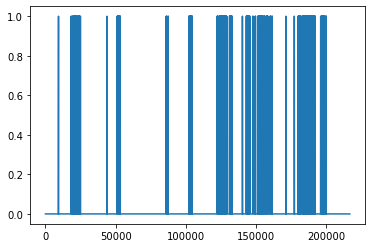

In [20]:
plt.plot(np.concatenate(post_processor.transcriptions,axis=0))

602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
212
72
313
602
602
602
602
602
602
602
602
602
602
602
602
602
602
123
302
273
12
383
93
20
38
7
34
25
18
13
16
10
27
4
36
9
56
10
35
11
27
25
36
15
36
90
32
11
16
141
21
16
32
2
1
353
14
207
75
29
34
45
57
38
29
11
10
304
133
36
348
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
598
602
602
602
602
602
602
602
602
602
602
431
28
180
23
75
10
58
16
83
21
13
6
12
11
31
20
11
26
15
119
6
93
24
144
108
23
311
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
13
120
462
592
7
69
520
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
454
106
22
177
53
130
12
35
6
41
132
10
9
50
53
124
86
39
254
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602

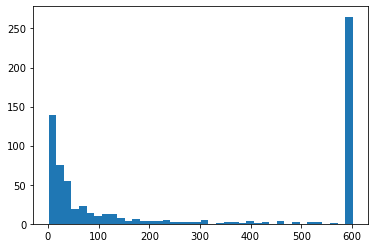

In [14]:
#comm = post_processor.get_comm_stats()
freq = post_processor.get_silence_stats()

(array([103.,  85.,  55.,  28.,  17.,  16.,  14.,  13.,  10.,   7.,  11.,
          8.,   2.,   2.,   6.,   3.,   1.,   4.,   3.,   5.,   1.,   2.,
          3.,   1.,   1.,   5.,   0.,   0.,   2.,   1.,   1.,   2.,   0.,
          4.,   0.,   2.,   0.,   1.,   2.,   0.,   2.,   0.,   1.,   1.,
          2.,   0.,   1.,   0.,   0., 265.]),
 array([  1.  ,  13.02,  25.04,  37.06,  49.08,  61.1 ,  73.12,  85.14,
         97.16, 109.18, 121.2 , 133.22, 145.24, 157.26, 169.28, 181.3 ,
        193.32, 205.34, 217.36, 229.38, 241.4 , 253.42, 265.44, 277.46,
        289.48, 301.5 , 313.52, 325.54, 337.56, 349.58, 361.6 , 373.62,
        385.64, 397.66, 409.68, 421.7 , 433.72, 445.74, 457.76, 469.78,
        481.8 , 493.82, 505.84, 517.86, 529.88, 541.9 , 553.92, 565.94,
        577.96, 589.98, 602.  ]),
 <BarContainer object of 50 artists>)

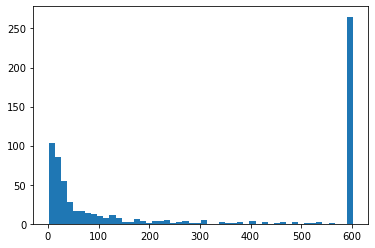

In [13]:
plt.hist(freq, bins = 50)

(array([75., 90., 55., 41., 36., 21.,  8.,  9.,  6.,  7.,  6.,  1.,  2.,
         0.,  2.,  1.,  0.,  0.,  0.,  3.,  1.,  2.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([   4.  ,   41.88,   79.76,  117.64,  155.52,  193.4 ,  231.28,
         269.16,  307.04,  344.92,  382.8 ,  420.68,  458.56,  496.44,
         534.32,  572.2 ,  610.08,  647.96,  685.84,  723.72,  761.6 ,
         799.48,  837.36,  875.24,  913.12,  951.  ,  988.88, 1026.76,
        1064.64, 1102.52, 1140.4 , 1178.28, 1216.16, 1254.04, 1291.92,
        1329.8 , 1367.68, 1405.56, 1443.44, 1481.32, 1519.2 , 1557.08,
        1594.96, 1632.84, 1670.72, 1708.6 , 1746.48, 1784.36, 1822.24,
        1860.12, 1898.  ]),
 <BarContainer object of 50 artists>)

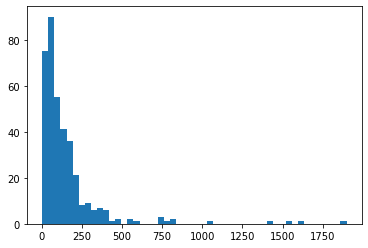

In [18]:
plt.hist(np.array(freq)[np.nonzero(np.array(freq) < 2000)], bins = 50)

(array([74., 55., 40., 39., 24., 15., 11., 11., 10., 15.,  9., 10.,  7.,
         6.,  3.,  9.,  6.,  4.,  3.,  2.,  2.,  1.,  9.,  0.,  0.,  0.,
         1.,  1.,  3.,  0.,  2.,  3.,  2.,  1.,  2.,  1.,  0.,  2.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  1.  ,  10.08,  19.16,  28.24,  37.32,  46.4 ,  55.48,  64.56,
         73.64,  82.72,  91.8 , 100.88, 109.96, 119.04, 128.12, 137.2 ,
        146.28, 155.36, 164.44, 173.52, 182.6 , 191.68, 200.76, 209.84,
        218.92, 228.  , 237.08, 246.16, 255.24, 264.32, 273.4 , 282.48,
        291.56, 300.64, 309.72, 318.8 , 327.88, 336.96, 346.04, 355.12,
        364.2 , 373.28, 382.36, 391.44, 400.52, 409.6 , 418.68, 427.76,
        436.84, 445.92, 455.  ]),
 <BarContainer object of 50 artists>)

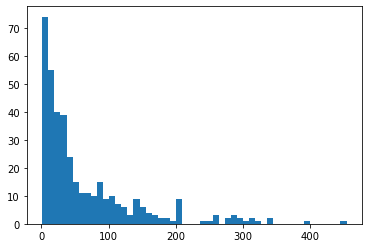

In [30]:
plt.hist(np.array(comm)[np.nonzero(np.array(comm) < 500)], bins = 50)

In [2]:
pkl_path = '/project/graziul/ra/ajays/whitelisted_vad_dict.pkl'
file = open(pkl_path,'rb')
vad_dict = pickle.load(file)
file.close()

final_freq_list = []

for idx,key in enumerate(vad_dict):
        print(idx)
        a = audio_file(key)
        a.get_slices(vad_dict)
        a.get_split_mfcc()
        a.get_split_frames()
        final_freq_list.append(a.get_split_labels())

0
(180600,)
1
(180600,)
2
(180600,)
3
(180600,)
4
(180600,)
5
(180600,)
6
(180600,)
7
(180600,)
8
(180600,)
9
(180600,)
10
(180600,)
11
(180600,)
12
(180600,)
13
(180600,)
14
(180600,)
15
(180600,)
16
(180600,)
17
(180600,)
18
(180600,)
19
(180600,)
20
(180600,)
21
(180600,)
22
(180600,)
23
(180600,)
24
(180600,)
25
(180600,)
26
(180600,)
27
(180600,)
28
(180600,)
29
(180600,)
30
(180600,)
31
(180600,)
32
(180600,)
33
(180600,)
34
(180600,)
35
(180600,)
36
(180600,)
37
(180600,)
38
(180600,)
39
(180600,)
40
(180600,)
41
(180600,)
42
(180600,)
43
(180600,)
44
(180600,)
45
(180600,)
46
(180600,)
47
(180600,)
48
(180600,)
49
(180600,)
50
(180600,)
51
(180600,)
52
(180600,)
53
(180600,)
54
(180600,)
55
(180600,)
56
(180600,)
57
(180600,)
58
(180600,)
59
(180600,)
60
(180600,)
61
(180600,)
62
(180600,)
63
(180600,)
64
(180600,)
65
(180600,)
66
(180600,)
67
(180600,)
68
(180600,)
69
(180600,)
70
(180600,)
71
(180600,)
72
(180600,)
73
(180600,)
74
(180600,)
75
(180600,)
76
(180600,)
77
(18060

In [3]:
final_freq_list

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 1., 1.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 1., 1.]]),
 array([[0., 0., 0., ..., 1., 1., 1.],
        [1., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 0., 0., 0.]]),
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 1.]]),
 arr

In [4]:
freq_list = []
for item in final_freq_list:
    freq_list.append(np.concatenate(np.array(item),axis=0))

In [12]:
def get_all_frequencies(transcript_list, axis = 1):
    final_freq_list = [] 
    freq_list = []
    for t in transcript_list:
        comm_prev= 0
        comm_end = 0
        start_flag = 0
        num_freqs = 0
        for j in range(t.size):
            if start_flag == 0 and t[j] == 1:
                num_freqs = num_freqs+1
                start_flag = 1

            elif start_flag == 1 and t[j] == 0:
                start_flag = 0
        print(num_freqs)
        freq_list.append(num_freqs)
    df = pd.DataFrame(freq_list)
    print(df.describe())
    plt.hist(freq_list, bins = 50)
    return freq_list

53
81
154
47
27
57
72
81
69
91
74
125
86
119
103
62
82
140
130
88
110
110
72
104
111
128
98
105
58
53
92
67
22
39
11
32
36
102
48
4
16
13
113
72
134
100
88
64
68
95
56
57
109
113
101
114
116
121
156
93
110
124
129
18
177
230
159
270
340
159
99
91
15
105
85
45
19
124
121
272
219
30
309
331
108
259
261
310
256
249
229
202
180
218
284
245
337
305
                0
count   98.000000
mean   122.102041
std     83.700434
min      4.000000
25%     67.250000
50%    103.500000
75%    150.500000
max    340.000000


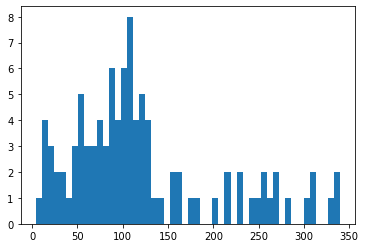

In [13]:
out = get_all_frequencies(freq_list)

In [ ]:
#Load from whitelisted.csv
datapath = '/project/graziul/data/whitelisted_vad_files.csv'
dataframe = pd.read_csv(datapath, header=None)

transcripts_path = '/project/graziul/transcripts/transcripts2021_10_27.csv'
transcripts_df = pd.read_csv(transcripts_path)
df_groups = transcripts_df.groupby(['zone','day','month','year','file'])
#clean_transcripts_df_files = [process_filename(transcripts_file) for transcripts_file in list(transcripts_df['file'])]
#print(clean_transcripts_df_files)

new_filename_list = []
chars_to_remove = ['_','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','.']
for idx,elt in enumerate(list(dataframe[0])):
    my_elt = process_filename(elt)
    new_filename_list.append(my_elt[:-1] + '.mp3')
    #new_filename_list.append(my_elt[:-1])
new_filename_list = list(set(new_filename_list))


In [4]:
print(torch.transpose(x,1,2).size())

torch.Size([300, 602, 40])


In [8]:
with torch.no_grad():
    y = post_processor.model(torch.transpose(x,1,2)).numpy()

In [16]:
y.reshape(300*602,1)

array([[0.00206194],
       [0.0008853 ],
       [0.00040744],
       ...,
       [0.11845128],
       [0.10818173],
       [0.11385687]], dtype=float32)

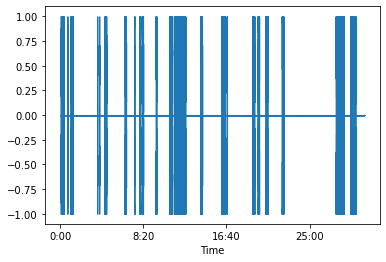

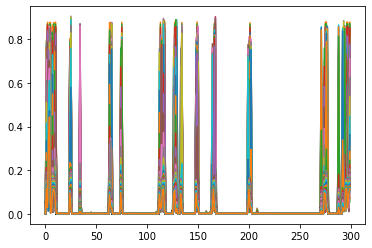

In [7]:
aud,sr = torchaudio.load(key)
aud = torch.squeeze(aud)
librosa.display.waveshow(aud.numpy())
plt.show()
post_processor.plot_transcripts(post_processor.add_pred(x,None))